# Attributable Protein Language Model (ESMattribution)
This notebook demonstrates training and getting per residue attribution from and ESM2 based model fine-tuned to predict a floating point fraction.  The demonstration uses fraction alpha helix predictions from the AlphaFold database (https://alphafold.ebi.ac.uk/) as calculated by the stride program (https://webclu.bio.wzw.tum.de/stride/).  If the sequence id is a uniprot id, the code can download the alphafold prediction and display the per residue RNA binding attribution as a false color.
This code can be run google colab at this link:
http://colab.research.google.com/github/jayunruh/ESMattribution/blob/main/train_attribute_fraction_alpha.ipynb

In [1]:
#if you are using this from google colab, you need the utility modules
#(everything else should already be installed)
!pip install py3dmol
import os
if(not os.path.exists('model_utils.py')):
    print('downloading model libraries')
    !wget https://raw.githubusercontent.com/jayunruh/ESMattribution/refs/heads/main/model_utils.py
if(not os.path.exists('jpdbtools.py')):
    !wget https://raw.githubusercontent.com/jayunruh/Jay_pdbtools/refs/heads/main/jpdbtools.py
    !wget https://raw.githubusercontent.com/jayunruh/Jay_pdbtools/refs/heads/main/jpdbtools2.py
else:
    print('libraries already downloaded')
#download the training data (upload by hand for customization)
if(not os.path.exists('yeast_af_ssstats2.csv')):
    print('downloading training data')
    !wget https://raw.githubusercontent.com/jayunruh/ESMattribution/refs/heads/main/yeast_af_ssstats2.csv

libraries already downloaded


In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sys
import jpdbtools as jutils
#model_utils contains the model definition
import model_utils
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import scipy.stats as ss
import requests

In [3]:
# Set the device (cpu or gpu)
device=model_utils.device
print(f"Using device: {device}")

Using device: cuda


In [4]:
#read in our data set
df=pd.read_csv('yeast_af_ssstats2.csv')
#now get a random subset for training and validation
subdf=df.sample(500).reset_index(drop=True)

# Split the data into training and validation sets
#frac is the fraction of the samples we will train with--the rest is used for validation
train_df = subdf.sample(frac=0.8)
val_df = subdf.drop(train_df.index)
train_df.to_csv('train_data2.csv')
val_df.to_csv('val_data2.csv')

print('training average fraction helix',train_df['f_alpha'].mean())
print('validation average fraction helix',val_df['f_alpha'].mean())

training average fraction helix 0.4054620874922447
validation average fraction helix 0.4280424965042215


In [5]:
# Load ESM-2 model and alphabet
esm_model,esmlayer,batch_converter,alphabet=model_utils.loadESMModel(33)
# set the hidden dimension for the esmlayer
hiddendim=32

Loading ESM-2 model...


Using cache found in /home/jru/.cache/torch/hub/facebookresearch_esm_main


ESM-2 model loaded.


In [6]:
# Create data loaders for training and validation
train_loader=model_utils.makeDataLoader(train_df,batch_converter,
                                        colnames=['upid','sequence','f_alpha'],shuffle=True)
val_loader=model_utils.makeDataLoader(val_df,batch_converter,
                                        colnames=['upid','sequence','f_alpha'],shuffle=False)

In [7]:
# Initialize the custom model
model = model_utils.ProteinPredictorWithESM(esm_model, esmlayer, hidden_dim=hiddendim).to(device)

# Define the loss function (Binary Cross Entropy with Logits) and optimizer (Adam)
criterion = nn.MSELoss()  # Suitable for binary classification, use BCEWithLogitsLoss for classification
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [8]:
losses,accuracies,val_losses,val_accuracies=model_utils.runTraining(model,optimizer,criterion,
                                                                    train_loader,val_loader,
                                                                    num_epochs=10,regression=True)

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0239, Accuracy: 0.891, Val_Loss: 0.0089, Val_Accuracy: 0.927


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.0137, Accuracy: 0.924, Val_Loss: 0.0086, Val_Accuracy: 0.930


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.0090, Accuracy: 0.938, Val_Loss: 0.0084, Val_Accuracy: 0.930


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0080, Accuracy: 0.941, Val_Loss: 0.0076, Val_Accuracy: 0.936


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0067, Accuracy: 0.946, Val_Loss: 0.0087, Val_Accuracy: 0.935


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0068, Accuracy: 0.946, Val_Loss: 0.0082, Val_Accuracy: 0.940


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0060, Accuracy: 0.952, Val_Loss: 0.0074, Val_Accuracy: 0.939


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0060, Accuracy: 0.948, Val_Loss: 0.0077, Val_Accuracy: 0.939


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0059, Accuracy: 0.950, Val_Loss: 0.0083, Val_Accuracy: 0.940


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0052, Accuracy: 0.955, Val_Loss: 0.0080, Val_Accuracy: 0.936


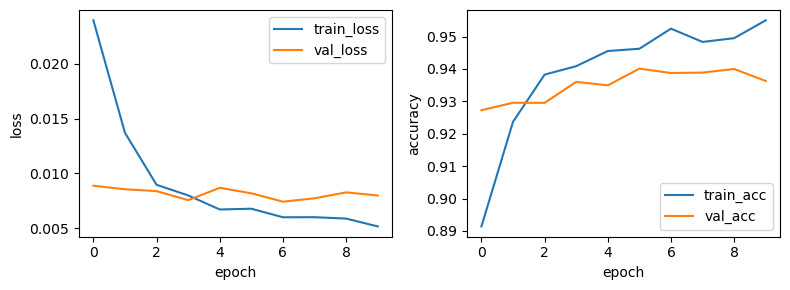

In [9]:
#plot the loss and accuracy curves
plt.figure(figsize=(8,3))
ax=plt.subplot(1,2,1)
ax.plot(losses)
ax.plot(val_losses)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train_loss','val_loss'])
ax=plt.subplot(1,2,2)
ax.plot(accuracies)
ax.plot(val_accuracies)
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train_acc','val_acc'])
plt.tight_layout()
plt.show()

In [10]:
# Save the trained model to a file
torch.save(model.state_dict(), 'protein_predictor_with_esm2.pth')
print("Model saved to protein_predictor_with_esm2.pth")

Model saved to protein_predictor_with_esm2.pth


In [33]:
# If we're starting the notebook here, load the model from file
model=model_utils.ProteinPredictorWithESM(esm_model,esmlayer, hidden_dim=hiddendim)
model.load_state_dict(torch.load('protein_predictor_with_esm2.pth'))
#esm_model.to_device(device)
_=model.to(device)
_=model.eval()
# Get the batch converter from the alphabet
batch_converter = alphabet.get_batch_converter()

In [34]:
#now get the attributions and predictions for a visualization selection of sequences
vis_df=df.sample(1000).sort_values('f_alpha').reset_index(drop=True)
vis_loader=model_utils.makeDataLoader(vis_df,batch_converter,
                                        colnames=['upid','sequence','f_alpha'],shuffle=False)
#note that usesigmoid needs to be false for regression predictions
attr_outputs,predictions=model_utils.evaluateSeqs(vis_loader,model,esm_model,esmlayer,device,usesigmoid=False)

getting attributions for 0 length tensor([200])
getting attributions for 1 length tensor([191])
getting attributions for 2 length tensor([399])
getting attributions for 3 length tensor([145])
getting attributions for 4 length tensor([343])
getting attributions for 5 length tensor([110])
getting attributions for 6 length tensor([212])
getting attributions for 7 length tensor([207])
getting attributions for 8 length tensor([128])
getting attributions for 9 length tensor([147])
getting attributions for 10 length tensor([72])
getting attributions for 11 length tensor([530])
getting attributions for 12 length tensor([315])
getting attributions for 13 length tensor([525])
getting attributions for 14 length tensor([588])
getting attributions for 15 length tensor([281])
getting attributions for 16 length tensor([1539])
getting attributions for 17 length tensor([470])
getting attributions for 18 length tensor([273])
getting attributions for 19 length tensor([484])
getting attributions for 20 le

In [35]:
#add our predictions to the worksheet and save for later
vis_df['prediction']=predictions
vis_df.to_csv('yeast_fraction_alpha_predictions.csv')

In [46]:
filt=vis_df.dropna()
regresults=ss.linregress(filt['f_alpha'],filt['prediction'])
r2=regresults.rvalue**2
print('R^2 = ',r2)

R^2 =  0.7768689940111285


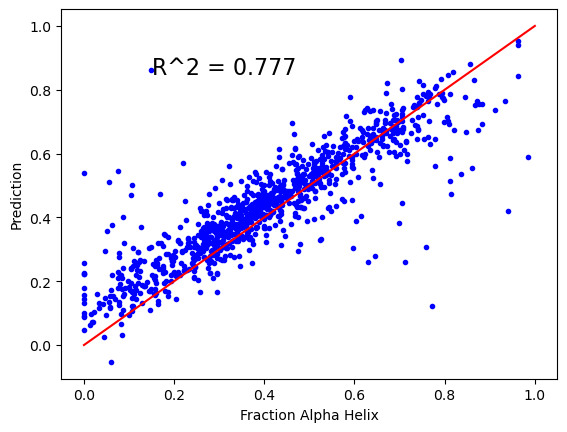

In [47]:
#now plot the positive and negative predictions
plt.plot(vis_df['f_alpha'],vis_df['prediction'],'b.')
plt.plot([0,1],[0,1],'r-')
plt.xlabel('Fraction Alpha Helix')
plt.ylabel('Prediction')
plt.text(0.15,0.85,f"R^2 = {r2:.3f}",fontsize=16)
plt.show()

In [48]:
#make the attributions into a matrix and save that
attrmat=np.full([len(vis_df),2000],np.nan)
for i in range(len(vis_df)):
    if(len(attr_outputs[i])>0):
        attrmat[i,:len(attr_outputs[i])]=attr_outputs[i]
np.save('yeast_fraction_alpha_attributions.npy',attrmat)

Text(0, 0.5, 'Test Sequence')

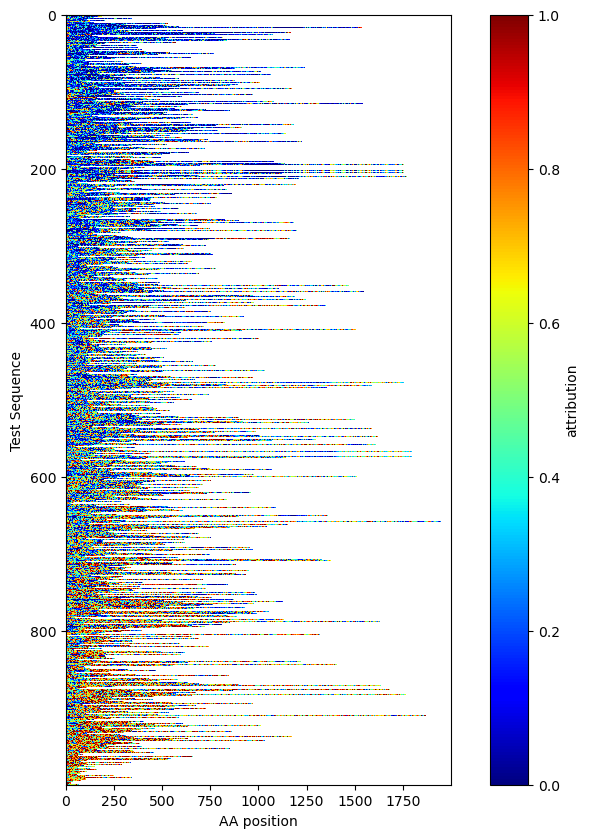

In [49]:
#now plot a heatmap of the attributions
plt.figure(figsize=(10,10))
plt.imshow(attrmat,cmap='jet',vmin=0,vmax=1,interpolation='None',aspect=4.0)
plt.colorbar(label='attribution')
plt.xlabel('AA position')
plt.ylabel('Test Sequence')

selected id: Q03730
label: 0.7633587786259542 prediction: 0.7885847091674805


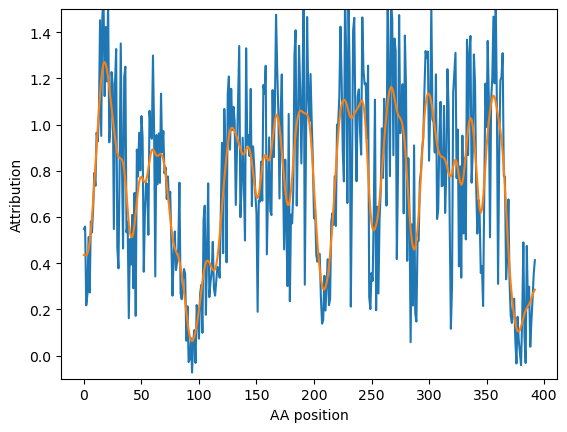

In [50]:
#show the attribution for a selected target
selidx=950
tid=vis_df.loc[selidx,'upid']
print('selected id:',tid)
print('label:',vis_df.loc[selidx,'f_alpha'],'prediction:',vis_df.loc[selidx,'prediction'])
seq=vis_df.loc[selidx,'sequence']
seqlen=min(len(seq),2000)
attr=attrmat[selidx,:seqlen]
smattr=ndi.gaussian_filter(attr,sigma=3)
plt.plot(attr)
plt.plot(smattr)
plt.ylim(-0.1,1.5)
plt.xlabel('AA position')
plt.ylabel('Attribution')
plt.show()

In [51]:
#finally load the alphafold structure
selid=tid
print('getting af2 prediction for id',selid)
url='https://alphafold.ebi.ac.uk/files/AF-'+selid+'-F1-model_v4.pdb'
pdbstr=requests.get(url).text

getting af2 prediction for id Q03730


In [52]:
pdbdf=jutils.cleanpdbdf(jutils.jpt2.getpdbdffromstr(pdbstr))
pdbdf.head()

,type,atom,atype,resname,chain,residue,x,y,z,unk,temp,element
0,ATOM,1,N,MET,A,1,-31.730000,-28.934000,-3.782,1.0,51.779999,N
1,ATOM,2,CA,MET,A,1,-31.173000,-27.815001,-2.990,1.0,51.779999,C
2,ATOM,3,C,MET,A,1,-29.725000,-27.521999,-3.370,1.0,51.779999,C
3,ATOM,4,CB,MET,A,1,-31.424000,-28.003000,-1.490,1.0,51.779999,C
4,ATOM,5,O,MET,A,1,-29.481001,-26.386999,-3.742,1.0,51.779999,O


In [53]:
#map the smoothed attribution to the residues
resmap={i+1:smattr[i] for i in range(len(smattr))}
pdbdf['temp']=pdbdf['residue'].map(resmap)
_=jutils.writepdbdf(pdbdf,selid+'_mapped.pdb')

In [54]:
view=jutils.py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',width=600,height=600)
view.addModel(jutils.writepdbdf(pdbdf),'pdb')
#view.addModel(pdbstr,'pdb') #to view the raw AF data
view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.0,'max':1.0}}})
#view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

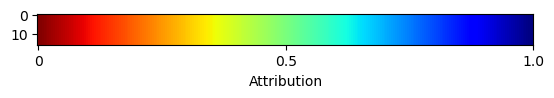

In [55]:
#show the color scale for the molecular plot
plt.imshow(np.tile(np.linspace(0,1,256),[16,1]),cmap='jet_r')
plt.xticks([0,128,256],[0,0.5,1.0])
plt.xlabel('Attribution')
plt.show()